### Import modules

In [1]:
!pip install transformers


In [2]:
!pip install tensorflow-text

In [3]:
pip install -q tf-models-official==2.4.0

Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow_text
import pandas as pd
import numpy as np
import torch
import torchtext
import tensorflow as tf

import seaborn as sns
import re

import wordcloud
from wordcloud import WordCloud

import matplotlib.pyplot as plt

import collections

from sklearn import preprocessing


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

import torch
from torchtext import data
import torch.nn as nn
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib as mlp
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, GlobalMaxPool1D, Bidirectional,Input,GlobalAveragePooling1D, BatchNormalization, Conv1D,GRU
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import Sequential,Model


import transformers
from transformers import AutoTokenizer,TFAutoModel,ElectraTokenizer, TFElectraForSequenceClassification, get_linear_schedule_with_warmup
from official import nlp


#### Parameters

### Functions

#### Reading

In [5]:
df_train = pd.read_csv('/kaggle/input/datasets-sarcasm/train_sarcasm.txt', names=['Text', 'label'], sep=';')
df_test = pd.read_csv('/kaggle/input/datasets-sarcasm/test_sarcasm.txt', names=['Text', 'label'], sep=';')

In [6]:
print(df_train.columns)
print(df_train.count()) ## small dataset

Index(['Text', 'label'], dtype='object')
Text     20032
label    20032
dtype: int64


In [7]:
df_train.isnull().sum()/df_train.count() ## no nulls

Text     0.0
label    0.0
dtype: float64

In [8]:
print(df_train.describe())  ## balancing data might not be a bad idea

              label
count  20032.000000
mean       0.476887
std        0.499478
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000


<Axes: ylabel='Text'>

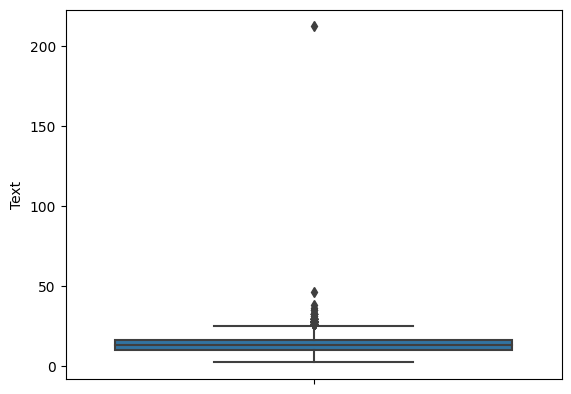

In [9]:
sns.boxplot(y=df_train['Text'].apply(lambda x: str.split(x)).apply(lambda x: len(x))) ## about 20 words per sentence should be okay for padding 


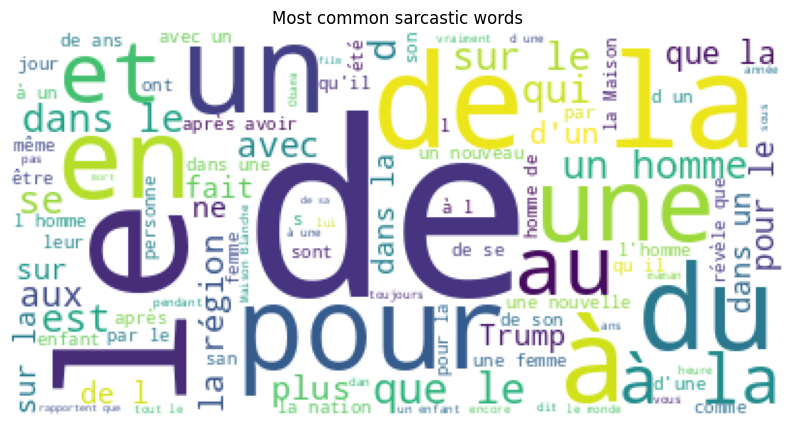

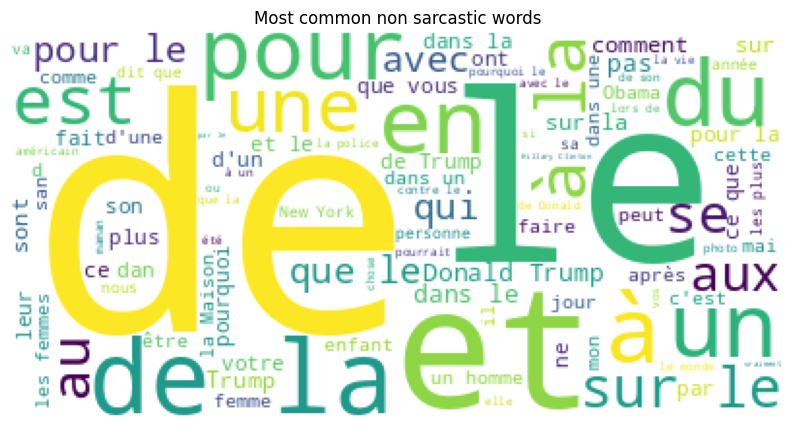

In [10]:
wc1 = WordCloud(
    background_color='white', 
    max_words=100)

wc1.generate(' '.join(text for text in df_train.loc[df_train['label'] == 1, 'Text']))

wc = WordCloud(
    background_color='white', 
    max_words=100)

wc.generate(' '.join(text for text in df_train.loc[df_train['label'] == 0, 'Text']))
plt.figure(figsize=(10,15))
plt.imshow(wc1)
plt.axis('off')
plt.title("Most common sarcastic words")
plt.figure(figsize=(10,15))
plt.imshow(wc)
plt.axis('off')
plt.title("Most common non sarcastic words")
plt.show()

### Preprocess

In [11]:
import nltk

In [12]:
nltk.download('stopwords')
nltk.download('wordnet')

# Initialiser les stopwords français
stop_words = set(stopwords.words("french"))

# Initialiser le lemmatizer pour la langue française
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:

def remove_stopwords(data):
    sentences=[]
    for text in data:
        text = ' '.join(word for word in text.split(' ') if word not in stop_words)
        sentences.append(text)
    return sentences
            

In [14]:
test_sentences = df_test['Text']
train_sentences = df_train['Text']

In [15]:
test_sentences=[re.sub(r'</?a(?:(?= )[^>]*)?>',' ',frase) for frase in test_sentences]
test_sentences=[re.sub(r'[^\w\s]',' ', frase) for frase in test_sentences] 
test_sentences=[re.sub(r'\n',' ', frase) for frase in train_sentences] 

train_sentences=[re.sub(r'</?a(?:(?= )[^>]*)?>',' ',frase) for frase in train_sentences]
train_sentences=[re.sub(r'[^\w\s]',' ', frase) for frase in train_sentences] 
train_sentences=[re.sub(r'\n',' ', frase) for frase in train_sentences] 

In [16]:
df= pd.DataFrame()
df['data'] = train_sentences
df['labels'] = df_train['label']

In [17]:
y_train=to_categorical(df_train['label'])
y_test=to_categorical(df_test['label'])

In [18]:
num_words=10000

tokenize=Tokenizer(num_words=num_words)

tokenize.fit_on_texts(train_sentences)
x_train=tokenize.texts_to_sequences(train_sentences)
x_test= tokenize.texts_to_sequences(test_sentences)

In [19]:
max_len = 20

In [20]:
x_train_pad=pad_sequences(x_train, maxlen= max_len,padding= "post")
x_test_pad=pad_sequences(x_test, maxlen= max_len, padding="post")

#### Definición de arquitecturas

Primero definiremos el modelo más simple el modelo LSTM con un embedding GloVe para agilizar el proceso de entrenamiento. 

#### Bert model

In [21]:
max_len=20
learning_rate = 2e-5
my_warmup = 3

In [22]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [23]:
X_train = np.zeros((len(df_train), max_len))
X_masks = np.zeros((len(df_train), max_len))

In [24]:
for i, text in enumerate(df_train['Text']):
    tokens = tokenizer.encode_plus(text, max_length= max_len, \
                      truncation=True, padding = "max_length", \
                      add_special_tokens =True, return_token_type_ids = False,
                     return_attention_mask = True)
    
    X_train[i,:], X_masks[i,:] = tokens['input_ids'], tokens['attention_mask']

In [25]:
labels = np.array(df_train['label'])

In [26]:
with open('X_train.npy','wb') as f:
    np.save(f, X_train)
with open('X_masks.npy','wb') as f:
    np.save(f, X_masks)
with open('labels.npy','wb') as f:
    np.save(f, labels)

In [27]:
with open('./X_train.npy','rb') as f:
    X_train = np.load(f)
with open('./X_masks.npy','rb') as f:
    X_masks = np.load(f)
with open('./labels.npy','rb') as f:
    labels = np.load(f)

In [28]:
tf.config.experimental.list_physical_devices('GPU')

[]

In [29]:
X_train.shape

(20032, 20)

In [30]:
X_masks.shape

(20032, 20)

In [31]:
dataset = tf.data.Dataset.from_tensor_slices((X_train,X_masks,labels))

In [32]:
def map_func(input_ids, masks , labels):
    return {'input_ids': input_ids, 'attention_mask':masks},labels

In [33]:
dataset = dataset.map(map_func)

In [34]:
dataset = dataset.shuffle(1000000).batch(32)

In [35]:
DS_LEN = len(list(dataset))

In [36]:
SPLIT = .8

train = dataset.take(round(DS_LEN * SPLIT))
validation = dataset.skip(round(DS_LEN * SPLIT))

In [ ]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

In [38]:
input_ids = tf.keras.layers.Input(shape=(max_len,), name = 'input_ids', dtype = 'int32')
mask = tf.keras.layers.Input(shape=(max_len,), name = 'attention_mask', dtype = 'int32')

In [39]:
embeddings = bert(input_ids, attention_mask = mask)[0]

In [40]:
epochs = 20

total_steps = DS_LEN * epochs



In [41]:
####Try to improve this 

X = tf.keras.layers.GlobalMaxPool1D()(embeddings)
X = tf.keras.layers.Dense(128, activation = 'selu')(X)
X = tf.keras.layers.Dropout(0.1)(X)
X = tf.keras.layers.Dense(32, activation = 'selu')(X)
y = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'outputs')(X)


model = tf.keras.Model(inputs=[input_ids, mask], outputs =y )

model.layers[2].trainable = False

In [42]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 20)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 20)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 20, 76                                       

In [43]:
num_steps = epochs * DS_LEN

optimizer, lr = transformers.create_optimizer(init_lr  = 2e-3, num_train_steps = num_steps,num_warmup_steps = 0.1*num_steps, weight_decay_rate =.01)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(train, validation_data = validation, 
                                        epochs=20, batch_size=32, callbacks=[EarlyStopping(patience=5, restore_best_weights=True), 
                                       ModelCheckpoint("ModeloBert.h5", save_best_weights=True)])

#### DistilBert

In [47]:
learning_rate = 2e-3


In [48]:
from transformers import DistilBertTokenizer, TFDistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased') 
model = TFDistilBertModel.from_pretrained('distilbert-base-cased')

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [51]:
X_train = np.zeros((len(df_train), max_len))
X_masks = np.zeros((len(df_train), max_len))

In [52]:
for i, text in enumerate(df_train['Text']):
    tokens = tokenizer.encode_plus(text, max_length= max_len, \
                      truncation=True, padding = "max_length", \
                      add_special_tokens =True, return_token_type_ids = False,
                     return_attention_mask = True)
    
    X_train[i,:], X_masks[i,:] = tokens['input_ids'], tokens['attention_mask']

In [55]:
labels = np.array(df_train['label'])

In [56]:
with open('X_train.npy','wb') as f:
    np.save(f, X_train)
with open('X_masks.npy','wb') as f:
    np.save(f, X_masks)
with open('labels.npy','wb') as f:
    np.save(f, labels)

In [57]:
with open('./X_train.npy','rb') as f:
    X_train = np.load(f)
with open('./X_masks.npy','rb') as f:
    X_masks = np.load(f)
with open('./labels.npy','rb') as f:
    labels = np.load(f)

In [59]:
dataset = tf.data.Dataset.from_tensor_slices((X_train,X_masks,labels))

In [60]:
def map_func(input_ids, masks , labels):
    return {'input_ids': input_ids, 'attention_mask':masks},labels

In [61]:
dataset = dataset.map(map_func)

In [62]:
dataset = dataset.shuffle(1000000).batch(32)

In [63]:
DS_LEN = len(list(dataset))

In [64]:
SPLIT = .8

train = dataset.take(round(DS_LEN * SPLIT))
validation = dataset.skip(round(DS_LEN * SPLIT))

In [66]:
input_ids = tf.keras.layers.Input(shape=(max_len,), name = 'input_ids', dtype = 'int32')
mask = tf.keras.layers.Input(shape=(max_len,),name = 'attention_mask', dtype = 'int32')


In [67]:
embeddings = model(input_ids,attention_mask = mask)[0]




In [68]:
####Try to improve this 
    
X = tf.keras.layers.Bidirectional(LSTM(max_len, return_sequences=True))(embeddings)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(128, activation = 'selu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(32, activation = 'selu')(X)
y = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'outputs')(X)


model = tf.keras.Model(inputs=[input_ids, mask], outputs =y )

model.layers[2].trainable = False

In [69]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 20)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 20)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_distil_bert_model (TFDi  TFBaseModelOutput(last_hid   6519091   ['input_ids[0][0]',           
 stilBertModel)              den_state=(None, 20, 768),   2          'attention_mask[0][0]']      
                              hidden_states=None, atten                                     

In [71]:
epochs = 20 

num_steps = epochs * DS_LEN

optimizer, lr = transformers.create_optimizer(init_lr  = 2e-3, num_train_steps = num_steps,num_warmup_steps = 0.1*num_steps, weight_decay_rate =.01)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [72]:
history = model.fit(train, validation_data = validation, 
                                        epochs=20, batch_size=32, callbacks=[EarlyStopping(patience=5, restore_best_weights=True), 
                                       ModelCheckpoint("ModeloDistilBert.h5", save_best_weights=True)])

Epoch 1/20
501/501 [==============================] - 368s 711ms/step - loss: 0.6594 - accuracy: 0.5951 - val_loss: 0.6054 - val_accuracy: 0.6655
Epoch 2/20
501/501 [==============================] - 354s 707ms/step - loss: 0.5647 - accuracy: 0.7008 - val_loss: 0.5104 - val_accuracy: 0.7455
Epoch 3/20
501/501 [==============================] - 369s 737ms/step - loss: 0.5354 - accuracy: 0.7216 - val_loss: 0.4801 - val_accuracy: 0.7790
Epoch 4/20
501/501 [==============================] - 357s 713ms/step - loss: 0.5032 - accuracy: 0.7496 - val_loss: 0.4452 - val_accuracy: 0.7857
Epoch 5/20
501/501 [==============================] - 358s 715ms/step - loss: 0.4826 - accuracy: 0.7655 - val_loss: 0.4582 - val_accuracy: 0.7825
Epoch 6/20
501/501 [==============================] - 361s 721ms/step - loss: 0.4583 - accuracy: 0.7839 - val_loss: 0.4173 - val_accuracy: 0.8018
Epoch 7/20
501/501 [==============================] - 376s 751ms/step - loss: 0.4499 - accuracy: 0.7850 - val_loss: 0.4057 -